# Household Load and PV Forecasting using LSTM

### Data Sources
* Location: Austin, TX
* Dates: 2016-01-01 to 2017-06-30
* Weather: Weather Underground. 
 * Link: https://www.wunderground.com/
 * Data resolution: ~ 1 hour
 * Access: open
* Energy: Pecan Street. 
 * Link: http://www.pecanstreet.org/
 * Data resolution: 1 minute
 * Access: universities

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt                        
%matplotlib inline

def load_data(filename):
	data = pd.read_csv(filename, index_col="datetime")
	return data

# forecast resolution
resol = 60
# household id selected
household = 93

                           hum     tempC
datetime                                
2014-12-30 00:00:00  85.000000  6.700000
2014-12-30 01:00:00  85.040000  6.694000
2014-12-30 02:00:00  87.575315  6.312892
2014-12-30 03:00:00  92.543018  5.703941
2014-12-30 04:00:00  97.666667  6.058333


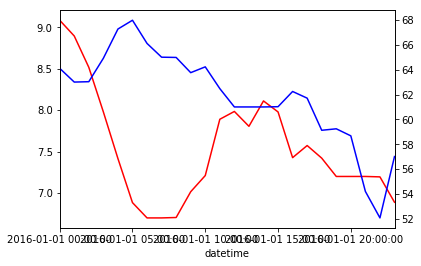

In [2]:
# load weather data
weather = load_data("preparedData/weather" + str(resol) + ".csv")
print(weather.head())

weather.loc['2016-01-01 00:00:00':'2016-01-01 23:00:00']['tempC'].plot(style='r')
weather.loc['2016-01-01 00:00:00':'2016-01-01 23:00:00']['hum'].plot(secondary_y=True, style='b')

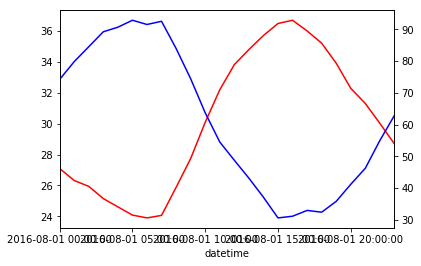

In [3]:
weather.loc['2016-08-01 00:00:00':'2016-08-01 23:00:00']['tempC'].plot(style='r')
weather.loc['2016-08-01 00:00:00':'2016-08-01 23:00:00']['hum'].plot(secondary_y=True, style='b')

                          use  gen
datetime                          
2015-12-23 00:00:00  1.174933  0.0
2015-12-23 01:00:00  0.899850  0.0
2015-12-23 02:00:00  0.432117  0.0
2015-12-23 03:00:00  0.402633  0.0
2015-12-23 04:00:00  0.573333  0.0


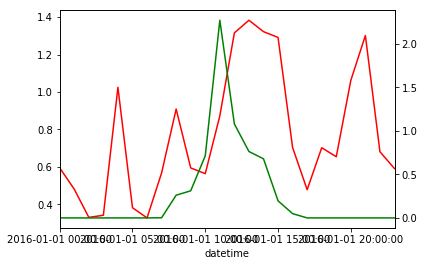

In [4]:
# load energy data
energy = load_data("preparedData/energy" + str(resol) + "_" + str(household) +".csv")
print(energy.head())

energy.loc['2016-01-01 00:00:00':'2016-01-01 23:00:00']['use'].plot(style='r')
energy.loc['2016-01-01 00:00:00':'2016-01-01 23:00:00']['gen'].plot(secondary_y=True, style='g')

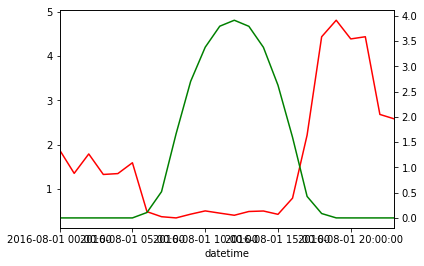

In [5]:
energy.loc['2016-08-01 00:00:00':'2016-08-01 23:00:00']['use'].plot(style='r')
energy.loc['2016-08-01 00:00:00':'2016-08-01 23:00:00']['gen'].plot(secondary_y=True, style='g')

# Photovoltaic Generation Forecasting

### Prepare Dataset to Feed LSTM

In [6]:
from datetime import date, datetime, timedelta
from sklearn.preprocessing import MinMaxScaler

def prepare_dataset_pv(weather, energy, resol):
	val_days = [1, 2, 3, 4, 5, 6, 7]
    
	# chunk data in days
	weather = weather.loc['2016-01-01':'2017-07-01']
	
	startDate = date(2016, 1, 1)
	endDate = date(2017, 6, 30)
	
	if resol == 60:
		minSt = '00'
	elif resol == 30:
		minSt = '30'
	elif resol == 15:
		minSt = '45'
		
	countTrain = 1
	countTest = 1
	countVal = 1
	
	while startDate <= endDate:
		startDateSt = startDate.strftime('%Y-%m-%d')
		startDatetimeSt = startDateSt + ' 00:00:00'
		endDatetimeSt = startDateSt +' 23:' + minSt + ':00'
		x = weather.loc[startDatetimeSt:endDatetimeSt]
		x = x.reset_index(drop=True)
		
		days = [1, 2, 3]
		
		for day in days:
			# last week consumption
			date_past = startDate - timedelta(days=day)
			date_past = date_past.strftime('%Y-%m-%d')
			startDatetimeSt = date_past + ' 00:00:00'
			endDatetimeSt = date_past + ' 23:' + minSt + ':00'
			x_i = energy.loc[startDatetimeSt:endDatetimeSt]
			'''
			x_i = pd.DataFrame([x_i])
			'''
			x_i = x_i.reset_index(drop=True)
			column_name = 'day_' + str(day)
			x_i = pd.DataFrame(x_i['gen'])
			x[column_name] = x_i
		
		x = x.as_matrix()
		#print(x.shape)
		x = x.reshape(1,x.shape[0], x.shape[1])
		#print(x.shape)
		
		
		
		# output on this day
		y = energy.loc[startDatetimeSt:endDatetimeSt]
		y = y.reset_index(drop=True)
		y = pd.DataFrame(y['gen']).as_matrix()
		#print(y.shape)
		y = y.reshape(1, y.shape[0])
		#print(y.shape)
		
		if startDate < date(2017, 1, 1):
			day = startDate.day
			if int(day) in val_days:
				# validation set
				if countVal == 1:
					x_val = x
					y_val = y
					countVal += 1
				else:
					x_val = np.concatenate((x_val, x), axis=0)
					y_val = np.concatenate((y_val, y), axis=0)
			else:
				# training set
				if countTrain == 1:
					x_train = x
					y_train = y
					countTrain += 1
				else:
					x_train = np.concatenate((x_train, x), axis=0)
					y_train = np.concatenate((y_train, y), axis=0)
		elif startDate < date(2017, 7, 1):
			if countTest == 1:
				x_test = x
				y_test = y
				countTest += 1
			else:
				x_test = np.concatenate((x_test, x), axis=0)
				y_test = np.concatenate((y_test, y), axis=0)
		
		# update date
		startDate = startDate + timedelta(days=1)
		
		
		
	
	print(x_train.shape)
	print(y_train.shape)
	print(x_val.shape)
	print(y_val.shape)
	print(x_test.shape)
	print(y_test.shape)
	
	# ensure all data is float
	x_train = x_train.astype('float32')
	y_train = y_train.astype('float32')
	x_val = x_val.astype('float32')
	y_val = y_val.astype('float32')
	x_test = x_test.astype('float32')
	y_test = y_test.astype('float32')
	
	n_features = x_train.shape[2]
	x_train = x_train.reshape((-1, n_features))
	x_val = x_val.reshape((-1, n_features))
	x_test = x_test.reshape((-1, n_features))
	
	scalerFeatures = MinMaxScaler(feature_range=(0, 1))
	x_train = scalerFeatures.fit_transform(x_train)
	x_val = scalerFeatures.transform(x_val)
	x_test = scalerFeatures.transform(x_test)
	
	x_train = x_train.reshape((-1, 1440//resol, n_features))
	x_val = x_val.reshape((-1, 1440//resol, n_features))
	x_test = x_test.reshape((-1, 1440//resol, n_features))
	
	# Normalize y
	y_train = y_train.reshape((-1))
	y_val = y_val.reshape((-1))
	y_test = y_test.reshape((-1))
	
	scalerOutput = MinMaxScaler(feature_range=(0, 1))
	y_train = scalerOutput.fit_transform(y_train)
	y_val = scalerOutput.transform(y_val)
	y_test = scalerOutput.transform(y_test)
	
	y_train = y_train.reshape((-1, 1440//resol))
	y_val = y_val.reshape((-1, 1440//resol))
	y_test = y_test.reshape((-1, 1440//resol))
	
	print(x_train.shape)
	print(y_train.shape)
	print(x_val.shape)
	print(y_val.shape)
	print(x_test.shape)
	print(y_test.shape)
	
	return x_train, y_train, x_val, y_val, x_test, y_test, scalerFeatures, scalerOutput

In [7]:
x_train, y_train, x_val, y_val, x_test, y_test, scalerFeatures, scalerOutput\
		= prepare_dataset_pv(weather, energy, resol)

(282, 24, 5)
(282, 24)
(84, 24, 5)
(84, 24)
(181, 24, 5)
(181, 24)
(282, 24, 5)
(282, 24)
(84, 24, 5)
(84, 24)
(181, 24, 5)
(181, 24)


/home/alberto/.local/lib/python3.5/site-packages/sklearn/preprocessing/data.py:321: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/home/alberto/.local/lib/python3.5/site-packages/sklearn/preprocessing/data.py:356: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/home/alberto/.local/lib/python3.5/site-packages/sklearn/preprocessing/data.py:356: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your dat

### Define RNN Model

In [8]:
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint
from keras.layers import LSTM, Dense

timesteps = 1440//resol
input_shape = (x_train.shape[1], x_train.shape[2])

# design network
modelGen = Sequential()
modelGen.add(LSTM(timesteps, return_sequences=True, input_shape=input_shape))
modelGen.add(LSTM(timesteps))
modelGen.add(Dense(timesteps, activation='sigmoid'))
print(modelGen.summary())

# compilation
# model.compile(loss='mae', optimizer='adam')
modelGen.compile(loss='mean_squared_error', optimizer='adam')

Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 24, 24)            2880      
_________________________________________________________________
lstm_2 (LSTM)                (None, 24)                4704      
_________________________________________________________________
dense_1 (Dense)              (None, 24)                600       
Total params: 8,184
Trainable params: 8,184
Non-trainable params: 0
_________________________________________________________________
None


### Training Model 

Train on 282 samples, validate on 84 samples
Epoch 1/1000
Epoch 00000: val_loss improved from inf to 0.16439, saving model to saved_models/weights.best.gen_60.hdf5
2s - loss: 0.1752 - val_loss: 0.1644
Epoch 2/1000
Epoch 00001: val_loss improved from 0.16439 to 0.13421, saving model to saved_models/weights.best.gen_60.hdf5
0s - loss: 0.1540 - val_loss: 0.1342
Epoch 3/1000
Epoch 00002: val_loss improved from 0.13421 to 0.09923, saving model to saved_models/weights.best.gen_60.hdf5
0s - loss: 0.1200 - val_loss: 0.0992
Epoch 4/1000
Epoch 00003: val_loss improved from 0.09923 to 0.07012, saving model to saved_models/weights.best.gen_60.hdf5
0s - loss: 0.0879 - val_loss: 0.0701
Epoch 5/1000
Epoch 00004: val_loss improved from 0.07012 to 0.04608, saving model to saved_models/weights.best.gen_60.hdf5
0s - loss: 0.0604 - val_loss: 0.0461
Epoch 6/1000
Epoch 00005: val_loss improved from 0.04608 to 0.03194, saving model to saved_models/weights.best.gen_60.hdf5
0s - loss: 0.0397 - val_loss: 0.0319

Epoch 00051: val_loss improved from 0.01755 to 0.01754, saving model to saved_models/weights.best.gen_60.hdf5
0s - loss: 0.0175 - val_loss: 0.0175
Epoch 53/1000
Epoch 00052: val_loss improved from 0.01754 to 0.01753, saving model to saved_models/weights.best.gen_60.hdf5
0s - loss: 0.0175 - val_loss: 0.0175
Epoch 54/1000
Epoch 00053: val_loss improved from 0.01753 to 0.01752, saving model to saved_models/weights.best.gen_60.hdf5
1s - loss: 0.0175 - val_loss: 0.0175
Epoch 55/1000
Epoch 00054: val_loss improved from 0.01752 to 0.01752, saving model to saved_models/weights.best.gen_60.hdf5
0s - loss: 0.0174 - val_loss: 0.0175
Epoch 56/1000
Epoch 00055: val_loss improved from 0.01752 to 0.01751, saving model to saved_models/weights.best.gen_60.hdf5
0s - loss: 0.0174 - val_loss: 0.0175
Epoch 57/1000
Epoch 00056: val_loss improved from 0.01751 to 0.01751, saving model to saved_models/weights.best.gen_60.hdf5
1s - loss: 0.0174 - val_loss: 0.0175
Epoch 58/1000
Epoch 00057: val_loss improved fro

Epoch 00102: val_loss improved from 0.01738 to 0.01738, saving model to saved_models/weights.best.gen_60.hdf5
0s - loss: 0.0173 - val_loss: 0.0174
Epoch 104/1000
Epoch 00103: val_loss improved from 0.01738 to 0.01738, saving model to saved_models/weights.best.gen_60.hdf5
0s - loss: 0.0173 - val_loss: 0.0174
Epoch 105/1000
Epoch 00104: val_loss improved from 0.01738 to 0.01738, saving model to saved_models/weights.best.gen_60.hdf5
0s - loss: 0.0173 - val_loss: 0.0174
Epoch 106/1000
Epoch 00105: val_loss improved from 0.01738 to 0.01738, saving model to saved_models/weights.best.gen_60.hdf5
1s - loss: 0.0173 - val_loss: 0.0174
Epoch 107/1000
Epoch 00106: val_loss improved from 0.01738 to 0.01737, saving model to saved_models/weights.best.gen_60.hdf5
1s - loss: 0.0173 - val_loss: 0.0174
Epoch 108/1000
Epoch 00107: val_loss improved from 0.01737 to 0.01737, saving model to saved_models/weights.best.gen_60.hdf5
0s - loss: 0.0173 - val_loss: 0.0174
Epoch 109/1000
Epoch 00108: val_loss improv

Epoch 00159: val_loss improved from 0.01734 to 0.01734, saving model to saved_models/weights.best.gen_60.hdf5
0s - loss: 0.0173 - val_loss: 0.0173
Epoch 161/1000
Epoch 00160: val_loss improved from 0.01734 to 0.01734, saving model to saved_models/weights.best.gen_60.hdf5
0s - loss: 0.0173 - val_loss: 0.0173
Epoch 162/1000
Epoch 00161: val_loss improved from 0.01734 to 0.01734, saving model to saved_models/weights.best.gen_60.hdf5
0s - loss: 0.0173 - val_loss: 0.0173
Epoch 163/1000
Epoch 00162: val_loss did not improve
0s - loss: 0.0173 - val_loss: 0.0173
Epoch 164/1000
Epoch 00163: val_loss improved from 0.01734 to 0.01734, saving model to saved_models/weights.best.gen_60.hdf5
0s - loss: 0.0173 - val_loss: 0.0173
Epoch 165/1000
Epoch 00164: val_loss did not improve
0s - loss: 0.0173 - val_loss: 0.0173
Epoch 166/1000
Epoch 00165: val_loss did not improve
0s - loss: 0.0173 - val_loss: 0.0173
Epoch 167/1000
Epoch 00166: val_loss improved from 0.01734 to 0.01734, saving model to saved_mode

Epoch 00219: val_loss improved from 0.00682 to 0.00665, saving model to saved_models/weights.best.gen_60.hdf5
0s - loss: 0.0067 - val_loss: 0.0066
Epoch 221/1000
Epoch 00220: val_loss improved from 0.00665 to 0.00612, saving model to saved_models/weights.best.gen_60.hdf5
0s - loss: 0.0065 - val_loss: 0.0061
Epoch 222/1000
Epoch 00221: val_loss improved from 0.00612 to 0.00598, saving model to saved_models/weights.best.gen_60.hdf5
0s - loss: 0.0063 - val_loss: 0.0060
Epoch 223/1000
Epoch 00222: val_loss improved from 0.00598 to 0.00582, saving model to saved_models/weights.best.gen_60.hdf5
0s - loss: 0.0059 - val_loss: 0.0058
Epoch 224/1000
Epoch 00223: val_loss did not improve
0s - loss: 0.0059 - val_loss: 0.0061
Epoch 225/1000
Epoch 00224: val_loss improved from 0.00582 to 0.00566, saving model to saved_models/weights.best.gen_60.hdf5
0s - loss: 0.0059 - val_loss: 0.0057
Epoch 226/1000
Epoch 00225: val_loss improved from 0.00566 to 0.00545, saving model to saved_models/weights.best.ge

Epoch 00283: val_loss did not improve
0s - loss: 0.0034 - val_loss: 0.0032
Epoch 285/1000
Epoch 00284: val_loss did not improve
0s - loss: 0.0035 - val_loss: 0.0034
Epoch 286/1000
Epoch 00285: val_loss improved from 0.00315 to 0.00310, saving model to saved_models/weights.best.gen_60.hdf5
0s - loss: 0.0034 - val_loss: 0.0031
Epoch 287/1000
Epoch 00286: val_loss did not improve
0s - loss: 0.0033 - val_loss: 0.0032
Epoch 288/1000
Epoch 00287: val_loss did not improve
0s - loss: 0.0033 - val_loss: 0.0032
Epoch 289/1000
Epoch 00288: val_loss improved from 0.00310 to 0.00310, saving model to saved_models/weights.best.gen_60.hdf5
0s - loss: 0.0034 - val_loss: 0.0031
Epoch 290/1000
Epoch 00289: val_loss did not improve
0s - loss: 0.0034 - val_loss: 0.0033
Epoch 291/1000
Epoch 00290: val_loss improved from 0.00310 to 0.00303, saving model to saved_models/weights.best.gen_60.hdf5
0s - loss: 0.0033 - val_loss: 0.0030
Epoch 292/1000
Epoch 00291: val_loss did not improve
0s - loss: 0.0032 - val_lo

Epoch 00357: val_loss did not improve
0s - loss: 0.0026 - val_loss: 0.0025
Epoch 359/1000
Epoch 00358: val_loss did not improve
0s - loss: 0.0026 - val_loss: 0.0028
Epoch 360/1000
Epoch 00359: val_loss did not improve
0s - loss: 0.0025 - val_loss: 0.0024
Epoch 361/1000
Epoch 00360: val_loss did not improve
0s - loss: 0.0024 - val_loss: 0.0024
Epoch 362/1000
Epoch 00361: val_loss did not improve
0s - loss: 0.0025 - val_loss: 0.0024
Epoch 363/1000
Epoch 00362: val_loss did not improve
0s - loss: 0.0023 - val_loss: 0.0023
Epoch 364/1000
Epoch 00363: val_loss improved from 0.00224 to 0.00222, saving model to saved_models/weights.best.gen_60.hdf5
0s - loss: 0.0022 - val_loss: 0.0022
Epoch 365/1000
Epoch 00364: val_loss improved from 0.00222 to 0.00214, saving model to saved_models/weights.best.gen_60.hdf5
0s - loss: 0.0021 - val_loss: 0.0021
Epoch 366/1000
Epoch 00365: val_loss did not improve
0s - loss: 0.0022 - val_loss: 0.0022
Epoch 367/1000
Epoch 00366: val_loss did not improve
0s - los

Epoch 00433: val_loss did not improve
0s - loss: 0.0016 - val_loss: 0.0017
Epoch 435/1000
Epoch 00434: val_loss did not improve
0s - loss: 0.0016 - val_loss: 0.0018
Epoch 436/1000
Epoch 00435: val_loss improved from 0.00166 to 0.00165, saving model to saved_models/weights.best.gen_60.hdf5
0s - loss: 0.0016 - val_loss: 0.0016
Epoch 437/1000
Epoch 00436: val_loss did not improve
0s - loss: 0.0016 - val_loss: 0.0017
Epoch 438/1000
Epoch 00437: val_loss did not improve
0s - loss: 0.0016 - val_loss: 0.0018
Epoch 439/1000
Epoch 00438: val_loss did not improve
0s - loss: 0.0016 - val_loss: 0.0017
Epoch 440/1000
Epoch 00439: val_loss did not improve
0s - loss: 0.0017 - val_loss: 0.0018
Epoch 441/1000
Epoch 00440: val_loss did not improve
0s - loss: 0.0017 - val_loss: 0.0017
Epoch 442/1000
Epoch 00441: val_loss did not improve
0s - loss: 0.0017 - val_loss: 0.0018
Epoch 443/1000
Epoch 00442: val_loss did not improve
0s - loss: 0.0016 - val_loss: 0.0017
Epoch 444/1000
Epoch 00443: val_loss did no

Epoch 00516: val_loss did not improve
0s - loss: 0.0015 - val_loss: 0.0018
Epoch 518/1000
Epoch 00517: val_loss did not improve
0s - loss: 0.0017 - val_loss: 0.0015
Epoch 519/1000
Epoch 00518: val_loss did not improve
0s - loss: 0.0015 - val_loss: 0.0018
Epoch 520/1000
Epoch 00519: val_loss did not improve
0s - loss: 0.0016 - val_loss: 0.0015
Epoch 521/1000
Epoch 00520: val_loss did not improve
0s - loss: 0.0016 - val_loss: 0.0017
Epoch 522/1000
Epoch 00521: val_loss did not improve
0s - loss: 0.0015 - val_loss: 0.0015
Epoch 523/1000
Epoch 00522: val_loss did not improve
0s - loss: 0.0014 - val_loss: 0.0015
Epoch 524/1000
Epoch 00523: val_loss did not improve
0s - loss: 0.0014 - val_loss: 0.0015
Epoch 525/1000
Epoch 00524: val_loss did not improve
0s - loss: 0.0014 - val_loss: 0.0014
Epoch 526/1000
Epoch 00525: val_loss did not improve
0s - loss: 0.0014 - val_loss: 0.0015
Epoch 527/1000
Epoch 00526: val_loss did not improve
0s - loss: 0.0014 - val_loss: 0.0015
Epoch 528/1000
Epoch 0052

Epoch 00600: val_loss did not improve
0s - loss: 0.0012 - val_loss: 0.0014
Epoch 602/1000
Epoch 00601: val_loss did not improve
0s - loss: 0.0012 - val_loss: 0.0014
Epoch 603/1000
Epoch 00602: val_loss did not improve
0s - loss: 0.0013 - val_loss: 0.0014
Epoch 604/1000
Epoch 00603: val_loss did not improve
0s - loss: 0.0014 - val_loss: 0.0014
Epoch 605/1000
Epoch 00604: val_loss did not improve
0s - loss: 0.0014 - val_loss: 0.0014
Epoch 606/1000
Epoch 00605: val_loss did not improve
0s - loss: 0.0015 - val_loss: 0.0015
Epoch 607/1000
Epoch 00606: val_loss did not improve
0s - loss: 0.0015 - val_loss: 0.0015
Epoch 608/1000
Epoch 00607: val_loss did not improve
0s - loss: 0.0014 - val_loss: 0.0015
Epoch 609/1000
Epoch 00608: val_loss did not improve
0s - loss: 0.0014 - val_loss: 0.0016
Epoch 610/1000
Epoch 00609: val_loss did not improve
0s - loss: 0.0015 - val_loss: 0.0014
Epoch 611/1000
Epoch 00610: val_loss did not improve
0s - loss: 0.0014 - val_loss: 0.0016
Epoch 612/1000
Epoch 0061

Epoch 00688: val_loss improved from 0.00124 to 0.00120, saving model to saved_models/weights.best.gen_60.hdf5
0s - loss: 0.0012 - val_loss: 0.0012
Epoch 690/1000
Epoch 00689: val_loss did not improve
0s - loss: 0.0012 - val_loss: 0.0014
Epoch 691/1000
Epoch 00690: val_loss did not improve
0s - loss: 0.0013 - val_loss: 0.0013
Epoch 692/1000
Epoch 00691: val_loss did not improve
0s - loss: 0.0013 - val_loss: 0.0013
Epoch 693/1000
Epoch 00692: val_loss did not improve
0s - loss: 0.0013 - val_loss: 0.0014
Epoch 694/1000
Epoch 00693: val_loss did not improve
0s - loss: 0.0013 - val_loss: 0.0014
Epoch 695/1000
Epoch 00694: val_loss did not improve
0s - loss: 0.0015 - val_loss: 0.0015
Epoch 696/1000
Epoch 00695: val_loss did not improve
0s - loss: 0.0014 - val_loss: 0.0014
Epoch 697/1000
Epoch 00696: val_loss did not improve
0s - loss: 0.0014 - val_loss: 0.0013
Epoch 698/1000
Epoch 00697: val_loss did not improve
0s - loss: 0.0012 - val_loss: 0.0013
Epoch 699/1000
Epoch 00698: val_loss did no

Epoch 00775: val_loss did not improve
0s - loss: 0.0012 - val_loss: 0.0014
Epoch 777/1000
Epoch 00776: val_loss did not improve
0s - loss: 0.0012 - val_loss: 0.0014
Epoch 778/1000
Epoch 00777: val_loss did not improve
0s - loss: 0.0012 - val_loss: 0.0012
Epoch 779/1000
Epoch 00778: val_loss did not improve
0s - loss: 0.0011 - val_loss: 0.0013
Epoch 780/1000
Epoch 00779: val_loss did not improve
0s - loss: 0.0011 - val_loss: 0.0013
Epoch 781/1000
Epoch 00780: val_loss did not improve
0s - loss: 0.0011 - val_loss: 0.0013
Epoch 782/1000
Epoch 00781: val_loss did not improve
0s - loss: 0.0011 - val_loss: 0.0012
Epoch 783/1000
Epoch 00782: val_loss did not improve
0s - loss: 0.0011 - val_loss: 0.0012
Epoch 784/1000
Epoch 00783: val_loss did not improve
0s - loss: 0.0010 - val_loss: 0.0012
Epoch 785/1000
Epoch 00784: val_loss did not improve
0s - loss: 0.0011 - val_loss: 0.0012
Epoch 786/1000
Epoch 00785: val_loss did not improve
0s - loss: 0.0011 - val_loss: 0.0013
Epoch 787/1000
Epoch 0078

Epoch 00864: val_loss did not improve
0s - loss: 9.8505e-04 - val_loss: 0.0012
Epoch 866/1000
Epoch 00865: val_loss did not improve
0s - loss: 9.7261e-04 - val_loss: 0.0012
Epoch 867/1000
Epoch 00866: val_loss did not improve
0s - loss: 9.5944e-04 - val_loss: 0.0012
Epoch 868/1000
Epoch 00867: val_loss improved from 0.00114 to 0.00111, saving model to saved_models/weights.best.gen_60.hdf5
0s - loss: 9.6254e-04 - val_loss: 0.0011
Epoch 869/1000
Epoch 00868: val_loss did not improve
0s - loss: 9.4045e-04 - val_loss: 0.0011
Epoch 870/1000
Epoch 00869: val_loss improved from 0.00111 to 0.00111, saving model to saved_models/weights.best.gen_60.hdf5
0s - loss: 9.4963e-04 - val_loss: 0.0011
Epoch 871/1000
Epoch 00870: val_loss did not improve
0s - loss: 9.4700e-04 - val_loss: 0.0012
Epoch 872/1000
Epoch 00871: val_loss did not improve
0s - loss: 9.5081e-04 - val_loss: 0.0012
Epoch 873/1000
Epoch 00872: val_loss did not improve
0s - loss: 9.5453e-04 - val_loss: 0.0012
Epoch 874/1000
Epoch 0087

Epoch 00951: val_loss did not improve
0s - loss: 9.1127e-04 - val_loss: 0.0011
Epoch 953/1000
Epoch 00952: val_loss did not improve
0s - loss: 9.0856e-04 - val_loss: 0.0011
Epoch 954/1000
Epoch 00953: val_loss did not improve
0s - loss: 9.0615e-04 - val_loss: 0.0011
Epoch 955/1000
Epoch 00954: val_loss did not improve
0s - loss: 9.2389e-04 - val_loss: 0.0011
Epoch 956/1000
Epoch 00955: val_loss did not improve
0s - loss: 9.2754e-04 - val_loss: 0.0011
Epoch 957/1000
Epoch 00956: val_loss did not improve
0s - loss: 9.1446e-04 - val_loss: 0.0011
Epoch 958/1000
Epoch 00957: val_loss did not improve
0s - loss: 9.1897e-04 - val_loss: 0.0011
Epoch 959/1000
Epoch 00958: val_loss did not improve
0s - loss: 9.2888e-04 - val_loss: 0.0011
Epoch 960/1000
Epoch 00959: val_loss did not improve
0s - loss: 9.3605e-04 - val_loss: 0.0012
Epoch 961/1000
Epoch 00960: val_loss did not improve
0s - loss: 9.4256e-04 - val_loss: 0.0011
Epoch 962/1000
Epoch 00961: val_loss did not improve
0s - loss: 9.7167e-04 

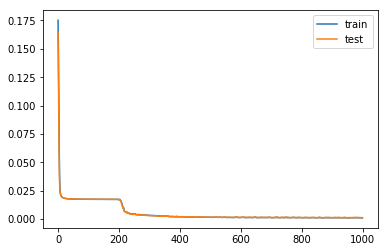

In [9]:
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.gen_'+str(resol)+'.hdf5',
								   verbose=1, save_best_only=True)
# fit network
history = modelGen.fit(x_train, y_train, epochs=1000, batch_size=30,
						validation_data=(x_val, y_val), verbose=2,
						callbacks=[checkpointer], shuffle=False)

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

### Testing Model

In [9]:
# reload parameters
modelGen.load_weights('saved_models/weights.best.gen_'+str(resol)+'.hdf5')

In [10]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

y_pred = modelGen.predict(x_test)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print("Mean Square Error: %f" % mse)
print("Mean Absolute Error: %f" % mae)

Mean Square Error: 0.001216
Mean Absolute Error: 0.016907


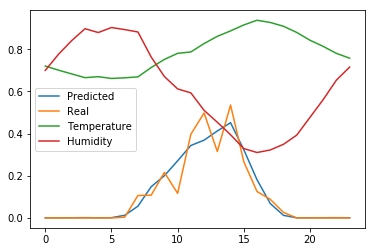

In [15]:
day = 175
plt.plot(y_pred[day,:], label='Predicted')
plt.plot(y_test[day,:], label='Real')
plt.plot(x_test[day,:,1], label='Temperature')
plt.plot(x_test[day,:,0], label='Humidity')
plt.legend()
plt.show()